In [1]:
import os
import igl
import subprocess
import numpy as np 
import open3d as o3d
import shapeworks as sw
import meshplot as mp
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from sklearn.decomposition import PCA

from ipywidgets import interact, widgets

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Save original particle reconstrustion meshes - left

In [2]:
orig_dir = 'mesh_left/'
if not os.path.exists(orig_dir):
    os.makedirs(orig_dir)

recon_dir = 'reconstruction_left/'
if not os.path.exists(recon_dir):
    os.makedirs(recon_dir)

meshes = sorted(glob("groomed/meshes/data/*left.vtk"))
particles = sorted(glob("shape_model/hippocampus_particles/*left_local.particles"))

for i, mesh_path in tqdm(enumerate(meshes)):
    mesh_name = mesh_path.split("\\")[-1].replace('.vtk', "")
    
    mesh = sw.Mesh(mesh_path)
    mesh.write(f"{orig_dir}{mesh_name}.ply")
    particle = sw.ParticleSystem([particles[i]]).ShapeAsPointSet(0)    
    
    warper = sw.MeshWarper()
    warper.generateWarp(mesh, particle)
    warped_mesh = warper.buildMesh(particle)
    
    warped_mesh.write(f"{recon_dir}{mesh_name}.ply")

511it [18:46,  2.20s/it]


## Save original particle reconstrustion meshes - left

In [3]:
orig_dir = 'mesh_right/'
if not os.path.exists(orig_dir):
    os.makedirs(orig_dir)

recon_dir = 'reconstruction_right/'
if not os.path.exists(recon_dir):
    os.makedirs(recon_dir)

meshes = sorted(glob("groomed/meshes/data/*right.vtk"))
particles = sorted(glob("shape_model/hippocampus_particles/*right_local.particles"))

for i, mesh_path in tqdm(enumerate(meshes)):
    mesh_name = mesh_path.split("\\")[-1].replace('.vtk', "")
    
    mesh = sw.Mesh(mesh_path)
    mesh.write(f"{orig_dir}{mesh_name}.ply")
    particle = sw.ParticleSystem([particles[i]]).ShapeAsPointSet(0)    
    
    warper = sw.MeshWarper()
    warper.generateWarp(mesh, particle)
    warped_mesh = warper.buildMesh(particle)
    
    warped_mesh.write(f"{recon_dir}{mesh_name}.ply")

511it [21:34,  2.53s/it]


## Hausdorff distance - left + right

100%|████████████████████████████████████████████████████████████████████████████| 511/511 [01:46<00:00,  4.79it/s]


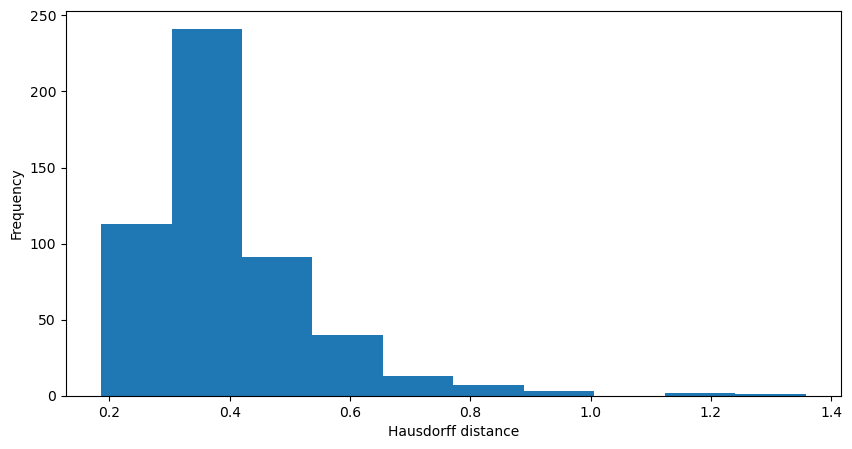

In [4]:
hausdorff_distances = []
left_originals = sorted(glob("./mesh_left/*.ply"))
#left_originals = os.listdir("mesh_left/")
left_reconstructions = sorted(glob("./reconstruction_left/*.ply"))
#left_reconstructions = os.listdir("reconstruction_left/")

right_originals = sorted(glob("./mesh_right/*.ply"))
#right_originals = os.listdir("mesh_right/")
right_reconstructions = sorted(glob("./reconstruction_right/*.ply"))
#right_reconstructions = os.listdir("reconstruction_right/")

for i in tqdm(range(len(left_originals))):
    left_mesh_o = o3d.io.read_triangle_mesh(left_originals[i])
    left_vertices_o = np.asarray(left_mesh_o.vertices)
    left_faces_o = np.asarray(left_mesh_o.triangles)
    left_mesh_r = o3d.io.read_triangle_mesh(left_reconstructions[i])
    left_vertices_r = np.asarray(left_mesh_r.vertices)
    left_faces_r = np.asarray(left_mesh_r.triangles)
    left_dist = igl.hausdorff(left_vertices_o, left_faces_o, left_vertices_r, left_faces_r)
    
    right_mesh_o = o3d.io.read_triangle_mesh(right_originals[i])
    right_vertices_o = np.asarray(right_mesh_o.vertices)
    right_faces_o = np.asarray(right_mesh_o.triangles)
    right_mesh_r = o3d.io.read_triangle_mesh(right_reconstructions[i])
    right_vertices_r = np.asarray(right_mesh_r.vertices)
    right_faces_r = np.asarray(right_mesh_r.triangles)
    right_dist = igl.hausdorff(right_vertices_o, right_faces_o, right_vertices_r, right_faces_r)
    
    hausdorff_distances.append(left_dist+right_dist)

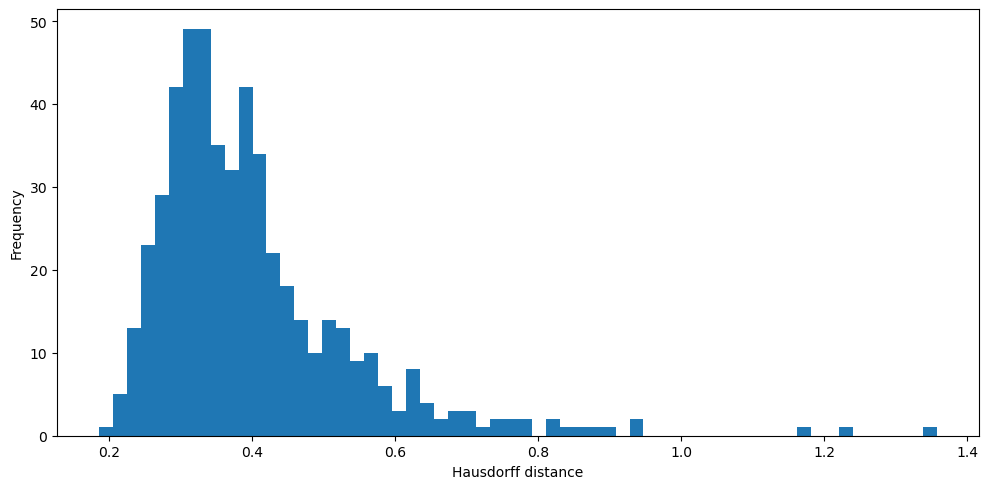

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(hausdorff_distances, bins=60)
plt.xlabel("Hausdorff distance")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/hausdorff.png")
plt.show()

## Plot worst reconstruction

In [16]:
shading = {"wireframe":True, "wire_width": 1, "wire_color": "yellow"}

idx = np.argmax(hausdorff_distances)
error = np.max(hausdorff_distances)

left_vertices_o, left_faces_o = igl.read_triangle_mesh(left_originals[idx])
left_vertices_r, left_faces_r = igl.read_triangle_mesh(left_reconstructions[idx])

right_vertices_o, right_faces_o = igl.read_triangle_mesh(right_originals[idx])
right_vertices_r, right_faces_r = igl.read_triangle_mesh(right_reconstructions[idx])

print("[INFO]: Original: red | Reconstruction: gray")
print(f"[INFO]: Index of worst reconstruction: {idx}")
print(f"[INFO]: Reconstruction error: {error}")

p = mp.plot(v=left_vertices_o, f=left_faces_o, c=np.array([0.7,0.1,0.1])) #shading=shading)
p.add_mesh(v=left_vertices_r, f=left_faces_r, c=np.array([0.9,0.9,0.9]))
p.add_mesh(v=right_vertices_o, f=right_faces_o, c=np.array([0.7,0.1,0.1])) #shading=shading)
p.add_mesh(v=right_vertices_r, f=right_faces_r, c=np.array([0.9,0.9,0.9]))
p.save("figures/worst_reconstruction.png")

[INFO]: Original: red | Reconstruction: gray
[INFO]: Index of worst reconstruction: 193
[INFO]: Reconstruction error: 1.3574935140627709


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(90.463401…

Plot saved to file figures/worst_reconstruction.png.html.
